# 🕵️ Autoenkoder: Wykrywanie Anomalii (Unsupervised Learning)

Większość AI to "Uczenie Nadzorowane" (pokazujemy: to jest kot, to jest pies).
Wykrywanie anomalii to "Uczenie Nienadzorowane". Mamy tylko poprawne dane ("Normalne zachowanie").

Budujemy sieć typu **Autoencoder**:
1.  **Encoder:** Kompresuje dane wejściowe do małego wektora (tzw. Latent Space).
2.  **Bottleneck:** Wąskie gardło. Zmusza sieć do zapamiętania tylko najważniejszych cech (wzorca), a odrzucenia szumu.
3.  **Decoder:** Próbuje odtworzyć oryginał z tego małego wektora.

**Zasada działania:**
Trenujemy sieć TYLKO na normalnych danych (np. poprawny rytm serca).
*   Gdy przyjdzie poprawny rytm -> Błąd rekonstrukcji będzie niski.
*   Gdy przyjdzie arytmia (anomalia) -> Sieć zgłupieje, błąd będzie wysoki. **Alarm!**

Dane normalne: torch.Size([990, 10])
Dane anomalii: torch.Size([990, 10])


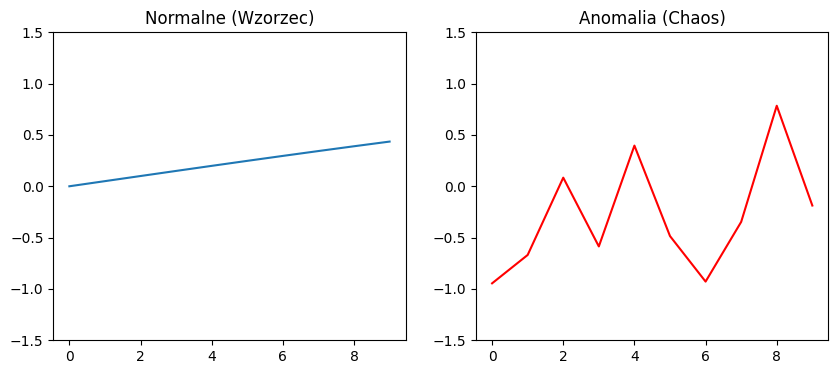

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. GENERUJEMY DANE (Symulacja EKG)
# Normalne dane: Sinusoida (Rytm serca)
# Anomalie: Szum / Zakłócenia

t = np.linspace(0, 50, 1000)
x_normal = np.sin(t)
x_anomaly = np.random.uniform(-1, 1, 1000) # Kompletny chaos

# Tniemy na kawałki po 10 punktów (Input Size = 10)
def create_sequences(data, seq_len=10):
    seqs = []
    for i in range(len(data) - seq_len):
        seqs.append(data[i:i+seq_len])
    return np.array(seqs)

X_normal = create_sequences(x_normal)
X_anomaly = create_sequences(x_anomaly)

# Zamiana na Tensory
X_normal_torch = torch.tensor(X_normal, dtype=torch.float32)
X_anomaly_torch = torch.tensor(X_anomaly, dtype=torch.float32)

print(f"Dane normalne: {X_normal_torch.shape}")
print(f"Dane anomalii: {X_anomaly_torch.shape}")

# Wizualizacja
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(X_normal[0])
plt.title("Normalne (Wzorzec)")
plt.ylim(-1.5, 1.5)

plt.subplot(1, 2, 2)
plt.plot(X_anomaly[0], color='r')
plt.title("Anomalia (Chaos)")
plt.ylim(-1.5, 1.5)
plt.show()

## Budowa Autoenkodera

Nasza sieć będzie miała kształt klepsydry:
*   Wejście: 10
*   Ukryta: 5 (Encoder - kompresja)
*   Bottleneck: 2 (Maksymalna kompresja - sedno danych)
*   Ukryta: 5 (Decoder - dekompresja)
*   Wyjście: 10

In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder: 10 -> 5 -> 2
        self.encoder = nn.Sequential(
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 2), # Bottleneck
            nn.ReLU()
        )
        
        # Decoder: 2 -> 5 -> 10
        self.decoder = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 10),
            # Na wyjściu Tanh, bo nasze dane są od -1 do 1 (jak sinus)
            nn.Tanh() 
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Autoencoder().to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=2, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=10, bias=True)
    (3): Tanh()
  )
)


## Trening (Tylko na Normalnych!)

To jest kluczowe. Nie pokazujemy modelowi ani jednej anomalii.
Chcemy, żeby stał się ekspertem od "normalności".

Jako funkcję błędu użyjemy **MSE (Mean Squared Error)** - bo chcemy, żeby wejście i wyjście były identyczne.

Epoka 0 | Błąd rekonstrukcji: 0.577251
Epoka 50 | Błąd rekonstrukcji: 0.069887
Epoka 100 | Błąd rekonstrukcji: 0.016341
Epoka 150 | Błąd rekonstrukcji: 0.013303
Epoka 200 | Błąd rekonstrukcji: 0.013076
Epoka 250 | Błąd rekonstrukcji: 0.012925
Epoka 300 | Błąd rekonstrukcji: 0.012765
Epoka 350 | Błąd rekonstrukcji: 0.012592
Epoka 400 | Błąd rekonstrukcji: 0.012422
Epoka 450 | Błąd rekonstrukcji: 0.012251


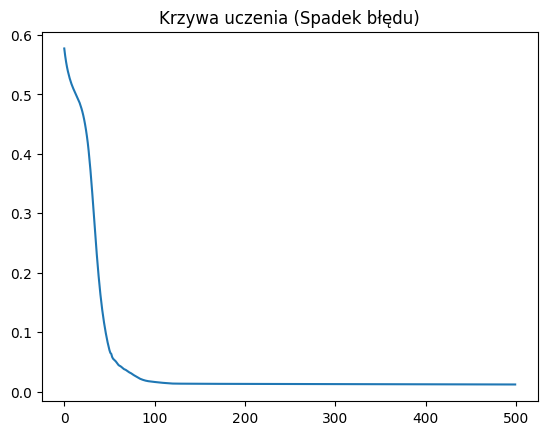

In [3]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

# Używamy 80% normalnych danych do treningu
train_size = int(0.8 * len(X_normal_torch))
train_data = X_normal_torch[:train_size].to(device)
test_data = X_normal_torch[train_size:].to(device) # Reszta normalnych do testu

epochs = 500
losses = []

for epoch in range(epochs):
    model.train()
    
    # 1. Forward (Autoenkoder próbuje odtworzyć wejście)
    output = model(train_data)
    
    # 2. Loss (Porównujemy wyjście z wejściem!)
    loss = loss_fn(output, train_data)
    
    # 3. Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if epoch % 50 == 0:
        print(f"Epoka {epoch} | Błąd rekonstrukcji: {loss.item():.6f}")

plt.plot(losses)
plt.title("Krzywa uczenia (Spadek błędu)")
plt.show()

## Detekcja: Moment Prawdy

Teraz wrzucimy do sieci dwa rodzaje danych, których nigdy nie widziała podczas treningu:
1.  **Testowe Normalne** (powinna je ładnie odtworzyć).
2.  **Anomalie** (powinna się wyłożyć).

Policzymy **Błąd Rekonstrukcji** dla każdego przypadku.

Średni błąd dla Normalnych: 0.0123
Średni błąd dla Anomalii:   0.3264


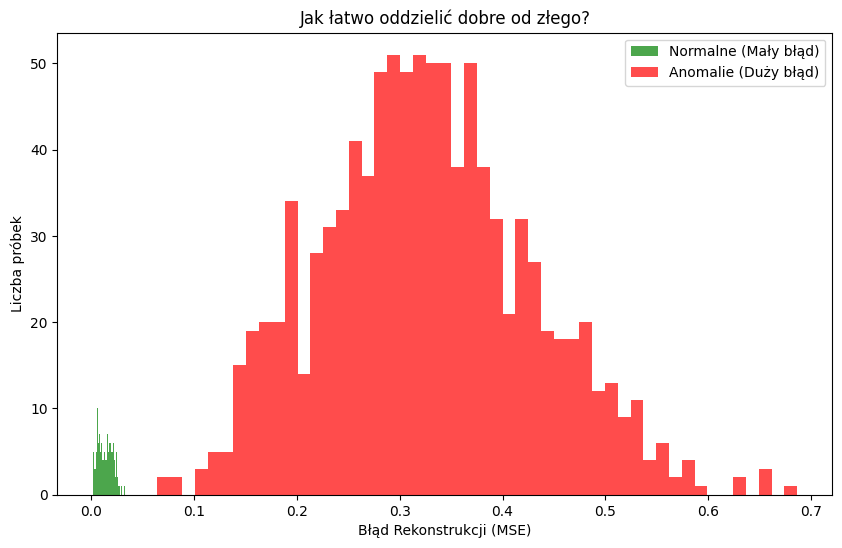

In [4]:
model.eval()
X_anomaly_torch = X_anomaly_torch.to(device)

with torch.no_grad():
    # 1. Sprawdzamy normalne dane
    pred_normal = model(test_data)
    # Liczymy błąd dla każdego przykładu osobno (reduce=False)
    loss_normal = torch.mean((pred_normal - test_data)**2, dim=1).cpu().numpy()
    
    # 2. Sprawdzamy anomalie
    pred_anomaly = model(X_anomaly_torch)
    loss_anomaly = torch.mean((pred_anomaly - X_anomaly_torch)**2, dim=1).cpu().numpy()

print(f"Średni błąd dla Normalnych: {np.mean(loss_normal):.4f}")
print(f"Średni błąd dla Anomalii:   {np.mean(loss_anomaly):.4f}")

# WIZUALIZACJA HISTOGRAMU BŁĘDÓW
plt.figure(figsize=(10, 6))
plt.hist(loss_normal, bins=50, alpha=0.7, label='Normalne (Mały błąd)', color='green')
plt.hist(loss_anomaly, bins=50, alpha=0.7, label='Anomalie (Duży błąd)', color='red')
plt.xlabel("Błąd Rekonstrukcji (MSE)")
plt.ylabel("Liczba próbek")
plt.legend()
plt.title("Jak łatwo oddzielić dobre od złego?")
plt.show()

## Ustalanie Progu (Threshold)

Patrząc na wykres, widzimy wyraźną granicę.
*   Normalne dane mają błąd bliski 0.
*   Anomalie mają błąd > 0.1 (na przykład).

Możemy ustawić **Threshold** (próg alarmowy). Wszystko, co ma błąd powyżej progu, oznaczamy jako atak/awarię.

In [5]:
# Ustalamy próg (np. średnia normalnych + 3 odchylenia standardowe)
threshold = np.mean(loss_normal) + 3 * np.std(loss_normal)
print(f"Ustalony próg alarmowy: {threshold:.4f}")

# Sprawdźmy skuteczność
n_detected = np.sum(loss_anomaly > threshold)
print(f"Wykryto {n_detected} z {len(loss_anomaly)} anomalii.")

if n_detected > len(loss_anomaly) * 0.9:
    print("✅ System działa wyśmienicie!")
else:
    print("⚠️ Trzeba dostroić model.")

Ustalony próg alarmowy: 0.0354
Wykryto 990 z 990 anomalii.
✅ System działa wyśmienicie!


## 🧠 Podsumowanie: Inteligencja przez Kompresję

Dlaczego to zadziałało?

**Tu jest haczyk.**
Wąskie gardło (Bottleneck) o rozmiarze 2 nie jest w stanie pomieścić informacji o losowym szumie (chaosie). Jest w stanie pomieścić tylko prostą regułę: "To jest sinusoida".

Dlatego sieć:
1.  Widząc sinusoidę -> Kompresuje ją do wzoru, a potem rozpakowuje. (Sukces).
2.  Widząc szum -> Próbuje go dopasować do wzoru sinusoidy, co się nie udaje. (Wysoki błąd).

To podejście stosuje się wszędzie, gdzie brakuje danych o awariach:
*   Monitorowanie serwerów.
*   Wykrywanie wad produktów na taśmie produkcyjnej (wizualne).
*   Analiza EKG w medycynie.